# 세팅

In [28]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [29]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [30]:
# 뽑아줘
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)#색변환
    image.flags.writeable = False                #이미지위에 뭘 적지마
    #model=mp_holistic
    results = model.process(image)              #분석
    image.flags.writeable = True               #이제는 적어도 되
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #
    return image, results

In [31]:
# 그려줘
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)   #자세
  

In [32]:
# 이쁘게 그려줘
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)  #자세
                               
  

# keypoints 시각화하기

In [89]:
#카메라 연결

cap = cv2.VideoCapture(0)   #영상로드

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic :

    while cap.isOpened():

        #프레임씩 읽어와
        ret,frame = cap.read() 

        #뽑아줘
        frame, results = mediapipe_detection(frame,holistic)
       
        
        #그려줘
        draw_styled_landmarks(frame,results)
        
        #보여줘
        cv2.imshow('me',frame)  

        
        
        if cv2.waitKey(10)& 0xFF == ord('q'): #q를 누르면 꺼줘
            break

    cap.release()
    cv2.destroyAllWindows()   

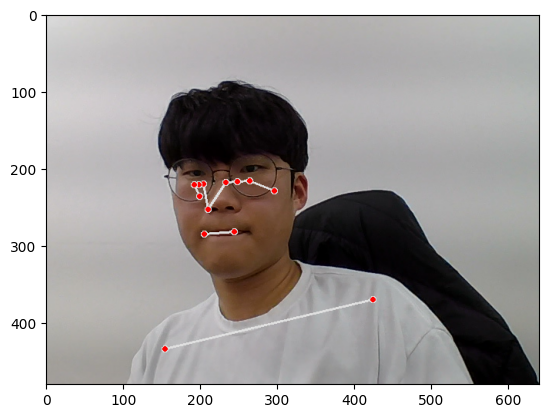

In [90]:
draw_landmarks(frame,results)
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [91]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten()if results.pose_landmarks else np.zeros(132) # 132=33*4...4=x,y,z,visible

    return pose

## 데이터 저장될 폴더 만들기

In [33]:
DATA_PATH = os.path.join('MP15_DATA')  #os.path.join( file name) 파일 이름만 정해주고 경로는 현재 경로이다.

actions = np.array(['walk','stand','sit'])

no_sequences =30 #영상 30개 만들어지는데

sequence_length = 30 #영상 1개의 프레임수는 100게

#os.path.join(dir_path, file name)으로 인자를 전달하면 
#디렉토리 경로에 파일 이름을 조합하고 그 path를 리턴합니다.


In [9]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass
#os.makedirs('./a/b/c', exist_ok=True)
#파일 '여러개'를 만든다. .(현재경로에)/a파일을 만들고/b파일을 만들고/c파일을 만든다


## keypoints  추출하기 폴더넣기

In [12]:
# keypoints 뽑아서 폴더에 numpy형식으로 넣기

cap = cv2.VideoCapture(1)
print('H:',cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print('w:',cap.get(cv2.CAP_PROP_FRAME_WIDTH))
w = round(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) 
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('C:/Users/Leeyourack/jookyoung/pose_code/video/extract2.avi', fourcc, fps, (w, h))

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # 액션 선택
    for action in actions:
        # 영상 선택
        for sequence in range(no_sequences):
            # 이미지 선택
            for frame_num in range(sequence_length):

                # 프레임 읽기
                ret, frame = cap.read()
                
                
                # 검출
                image, results = mediapipe_detection(frame, holistic)

                # 그리기
                draw_styled_landmarks(image, results)
                cv2.putText(image, ' frame :{}'.format(frame_num), (270,70), 
                               cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 155, 50), 2, cv2.LINE_AA)
                # 촬영 로직
                if frame_num == 0: 
                    
                    cv2.putText(image, 'STARTING COLLECTION', (140,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Video{}'.format(sequence), (30,70), 
                               cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 155, 50), 2, cv2.LINE_AA)
                    
                    #기다렸다가 시작하자
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1000) 
                else: 
                    cv2.putText(image, 'SAVE_{}_DATA'.format(action), (70,400), 
                               cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0, 255), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Video{}'.format(sequence), (30,70), 
                               cv2.FONT_HERSHEY_SIMPLEX, 2,  (255, 155, 50), 2, cv2.LINE_AA)
                    
                    cv2.imshow('OpenCV Feed', image)
                

                # keypoits 뽑기
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                #영상 저장
                out.write(image)

                #끄기
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

                
    out.release()                
    cap.release()
    cv2.destroyAllWindows()

H: 480.0
w: 640.0


# 

## 추출된 keypoints  폴더에서 가져와 사용하기 

In [35]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [36]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'walk': 0, 'stand': 1, 'sit': 2}

In [37]:
# 저장된 데이터 가져와 리스트에 넣기
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)    # res:이미지 하나의 keypoints
        sequences.append(window)  # wilndow:영상1의 keypoints  #sequences:영상30개의 keypoints
        labels.append(label_map[action])

## 데이터 전처리

In [39]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [41]:
X_train.shape

(85, 30, 132)

## 모델 생성

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [43]:
import tensorflow as tf

print(tf.__version__)
#2.10.0

2.10.0


In [23]:
log_dir = os.path.join('Log_MP115')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
model15 = Sequential() #순차적으로 모델의 레이어를 추가한다.
model15.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,132)))
model15.add(LSTM(128, return_sequences=True, activation='relu'))
model15.add(LSTM(64, return_sequences=False, activation='relu'))
model15.add(Dense(64, activation='relu'))
model15.add(Dense(32, activation='relu'))
model15.add(Dense(actions.shape[0], activation='softmax'))


In [25]:
model15.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

## 모델 학습

In [26]:
model15.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 8s 1s/step - loss: 1.0974 - categorical_accuracy: 0.3412
Epoch 2/2000
3/3 [==============================] - 4s 1s/step - loss: 1.0603 - categorical_accuracy: 0.4118
Epoch 3/2000
3/3 [==============================] - 4s 1s/step - loss: 0.8293 - categorical_accuracy: 0.6824
Epoch 4/2000
3/3 [==============================] - 4s 1s/step - loss: 0.7180 - categorical_accuracy: 0.5882
Epoch 5/2000
3/3 [==============================] - 4s 1s/step - loss: 0.6919 - categorical_accuracy: 0.6000
Epoch 6/2000
3/3 [==============================] - 4s 1s/step - loss: 0.6462 - categorical_accuracy: 0.6588
Epoch 7/2000
3/3 [==============================] - 4s 1s/step - loss: 0.6749 - categorical_accuracy: 0.6353
Epoch 8/2000
3/3 [==============================] - 4s 1s/step - loss: 0.6116 - categorical_accuracy: 0.6588
Epoch 9/2000
3/3 [==============================] - 4s 1s/step - loss: 0.5760 - categorical_accuracy: 0.6588
Epoch 10/2000
3/3 [

In [44]:
model15.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            50432     
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 204,995
Trainable params: 204,995
Non-trai

In [30]:
model15.save('test_model15')

INFO:tensorflow:Assets written to: test_model13\assets


In [31]:
#model.load_weights('C:/Users/Leeyourack/jookyoung/pose_code/test_model1')
model15.load_weights('test_model5')

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for test_model3

In [32]:

from scipy import stats

# 모델 사용 및 시각화

In [33]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [46]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [86]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.9

cap = cv2.VideoCapture(1)
f=1

w = round(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = 6
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('C:/Users/Leeyourack/jookyoung/pose_code/video/predict9.avi', fourcc, fps, (w, h))


# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        
        # Read feed
        ret, frame = cap.read()

       
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-20:]  #최근 30이미지 keypoints
        sx=w*keypoints[0]
        sy=h*keypoints[1]
        #30장이 모이면 모델을 가지고 예측시작
        if len(sequence) == 20:
            
            res = model15.predict(np.expand_dims(sequence, axis=0))[0] # 30장을 모델에 넣고 결과값을 얻는다
            predictions.append(np.argmax(res)) # predictions:[0,2,0,1,...]=[walk, sit, walk, stand]
            a = actions[np.argmax(res)]
            cv2.putText(image, f'{a}', (int(sx)+40,int(sy+10)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)
            
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                print('what?',np.unique(predictions[-10:])[0])
            
        #3. Viz logic
            '''if np.unique(predictions[-10:])[0]==np.argmax(res): #결과값의 최대일때의 인덱스와
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]'''

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        '''cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)'''
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        out.write(image)
           
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        f = f+1
    out.release()
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti